In [2]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from datetime import timedelta, datetime

sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_palette('Set2', n_colors=10)
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False) 

c:\Users\wooyong\anaconda3\envs\kwix\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
C:\Users\wooyong\AppData\Local\Temp/ipykernel_17512/2378865906.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


In [3]:
# df_1111 = pd.read_excel('track1_11번가.xlsx',sheet_name = None)
# df_11nnn = pd.read_excel('track1_네이버.xls',sheet_name = None)

# sheets_11 = list(df_1111.keys())
# df_11 = pd.DataFrame([])

# for i in sheets_11:
#     df1 = pd.read_excel('track1_11번가.xlsx',sheet_name = i)
#     df1['날짜'] = i
#     df_11 = pd.concat([df_11, df1])

# sheets_n = list(df_11nnn.keys())
# df_11 = pd.DataFrame([])

# for i in sheets_n:
#     df2 = pd.read_excel('track1_네이버.xls',sheet_name = i)
#     df2['날짜'] = i
#     df_11 = pd.concat([df_11, df2])
    

# report = df_11.profile_report(title='네이버 데이터')
# report.to_file('네이버 데이터.html')
# report = df_11.profile_report(title='11번가 데이터')
# report.to_file('11번가 데이터.html')

In [4]:
# df_11.to_pickle('df_11.pkl')
# df_11.to_pickle('df_11.pkl')
df_11 = pd.read_pickle('df_11.pkl')
df_11.reset_index(drop= True,inplace=True)

In [5]:
# df_11['주문일'] 날짜형식으로 전환 및 요일
df_11['주문일'] = pd.to_datetime(df_11['주문일'], format = '%Y%m%d')
df_11.insert(3, '구매연도', df_11['주문일'].dt.year)
df_11.insert(4, '구매월', df_11['주문일'].dt.month)
df_11.insert(5, '구매일', df_11['주문일'].dt.day)
df_11.insert(6, '구매요일', df_11['주문일'].dt.day_name('ko_KR'))


#운송장 등록일자 기준 도착일 지정, 운송장 등록 기준 반나절내에 택배사 도착, 12시 이후는 다음날로 설정함
df_11['운송장등록일자'] = pd.to_datetime(df_11['운송장등록일자'])
df_11['운송장등록일자_시간'] = df_11['운송장등록일자'].dt.time
df_11.insert(10,'운송장등록_도착날짜',df_11['운송장등록일자'].dt.floor('D'))
df_11.loc[df_11['운송장등록일자_시간'] >= pd.to_datetime('12:00:00').time(), '운송장등록_도착날짜'] = df_11.loc[df_11['운송장등록일자_시간'] >= pd.to_datetime('12:00:00').time(), '운송장등록_도착날짜'] + pd.DateOffset(days=1)


#배송기간 설정
df_11.insert(12,'배송기간',df_11['운송장등록_도착날짜'] - df_11['주문일'])

# 주문일의 요일에 따라 주말 또는 평일로 구분하는 컬럼 생성
df_11['요일'] = df_11['주문일'].dt.weekday
df_11.insert(7,'평일/주말',df_11['요일'].apply(lambda x: '주말' if x >= 5 else '평일') )

#필요없는 셀 정리
df_11.drop(columns = ['날짜','요일','운송장등록일자_시간'],inplace=True)

In [6]:
# 타켓으로 할 기념일 선정
기념일 = {'어린이날': '20220505',
          '어버이날': '20220508'}

# 기념일부터 일주일 전의기간 추출
기념일주간 = {}
for key, value in 기념일.items():
    기념일주간[key] = []
    기념일_날짜 = datetime.strptime(value, '%Y%m%d')
    주간_시작 = 기념일_날짜 - timedelta(weeks=1)
        
    # 주간 범위 내 모든 날짜 추가 (5월 이상만)
    while 주간_시작 <= 기념일_날짜:
        if 주간_시작.month == 5:
            기념일주간[key].append(주간_시작.strftime('%Y-%m-%d'))
        주간_시작 += timedelta(days=1)

기념일df_11 = df_11[df_11['주문일'].isin([date for lst in 기념일주간.values() for date in lst])];기념일df_11.head(3)


,거래처,거래처주문번호,주문일,구매연도,구매월,구매일,구매요일,평일/주말,사은품여부,출고예정일,...,자재명,초기자재수량,주문수량,취소수량,반품수량,배송유형,마감구분,플랜트 정보,단독배송여부,GS홈쇼핑주문번호
29030,외부몰_직거래_11번가(신),20220507433016811,2022-05-08,2022,5,8,일요일,주말,N,20220515,...,하얀설탕3KG_6개입/상온,12,12,0,0,택배배송,상온,동탄센터 > 동탄일반,N,NaN
30926,외부몰_직거래_11번가(신),20220508433044536,2022-05-08,2022,5,8,일요일,주말,N,20220515,...,다담/부대찌개양념 140G/24입/냉장,3,3,0,0,택배배송,냉장,동탄센터 > 동탄일반,N,NaN
30927,외부몰_직거래_11번가(신),20220508433044536,2022-05-08,2022,5,8,일요일,주말,N,20220515,...,다담/마파두부양념150G/냉장,3,3,0,0,택배배송,냉장,동탄센터 > 동탄일반,N,NaN


In [7]:
#자재명을 str타입으로 변경
df_11['자재명'] = df_11['자재명'].astype(str)

In [8]:
# 정규 표현식 패턴을 사용하여 *뒤의 숫자와 EA앞의 숫자를 추출
pattern1 = r'(?<=G\*)\d+'
pattern2 = r'(?<=\b)\d+(?=EA\b)'

def extract_numbers(text):
    if '*' in text:
        match = re.search(pattern1, text)
        if match:
            return match.group()
    elif 'EA' in text:
        match = re.search(pattern2, text)
        if match:
            return match.group()
    return None

df_11['실제_상품수량'] = df_11['자재명'].apply(extract_numbers)

In [9]:
def extract_numbers(text):
    if '*' in text:
        match = re.search(pattern1, text)
        if match:
            return match.group()
    elif 'EA' in text:
        match = re.search(pattern2, text)
        if match:
            return match.group()
    else:
        return 0
    return None

df_11['실질상품수량'] = df_11['자재명'].apply(extract_numbers)

In [10]:
df_11['실질상품수량'].fillna(1, inplace=True)
df_11['실질상품수량'] = df_11['실질상품수량'].astype(int)

#앞으로 수량으로 사용할 새로운 컬럼 정의
df_11['실질상품수량X주문수량'] = df_11['실질상품수량'] * df_11['주문수량']
df_11.query('실질상품수량 != 0')[['실질상품수량','주문수량','실질상품수량X주문수량']]

,실질상품수량,주문수량,실질상품수량X주문수량
10,2,0,0
11,2,0,0
18,2,1,2
19,2,2,4
25,2,1,2
...,...,...,...
172420,2,1,2
172421,2,2,4
172431,2,1,2
172432,2,1,2


In [11]:
#브랜드명 추출
pattern = r'(비비고|햇반|고메|백설|다시다|다담|스팸|맛밤|맛군밤|맥스봉|더건강한|즐거운동행|쁘띠첼|산들애|설탕|밥이랑|크레잇|밸런스밀|쿡킷|올리고당|요리당|물엿|식초|참좋은 조미김가루|천일염|파스타소스|가루|시럽|하선정|소금|알찬소시지|아메리칸스타일포크|빅소시지|행복한콩|고급면용|쉐프솔루션|푸드웨어|파우더|남원|물로만끓여도|유|기름|믹스|중력|박력|강력|분|고추장|된장|쌈장|비빔장|톡톡까먹어밤|한식예찬|아이미|쉐프솔루션|동그랑땡|CJ|특별한선택|함흥비빔냉면소스|프레시안구이|고기팡팡미트볼|고단백 두부면|미정당|오리지널후랑크|햄스빌|한입쏙 비엔나|프레시안|아티장|가쓰오|4무|주부초밥왕|제일제면소|삼호|얼큰우동|오리지널부어스트|청양초 매운물냉면|씨제이)'

def extract_brand(text):
    match = re.search(pattern, text)
    if match:
        return match.group()
    else:
        return None

df_11['브랜드'] = df_11['자재명'].apply(extract_brand)


In [12]:
# 자재명에 브랜드명이 포함되지 않은 상품들 브랜드로 변경
brand_mapping = {'남원' : '씨제이', '맛군밤' : '맛밤', '밥이랑' : '백설', '물로만 끓여도' : '해찬들', '유' : '백설', '기름' : '백설', '설탕' : '백설', '고추장' : '해찬들', '된장' : '해찬들', '쌈장' : '해찬들', '비빔장' : '해찬들', '함흥비빔냉면소스' : '씨제이', '고단백 두부면' : '즐거운 동행', '밸런스밀' : '씨제이', '요리당' : '백설', '올리고당' : '백설', '가루' : '백설', '참좋은 조미김가루' : '씨제이', '믹스' : '백설', '중력' : '백설', '박력' : '백설' ,'강력' : '백설', '분' : '백설', '소금': '백설', '식초' : '백설',
'물엿' : '백설',
'천일염' : '백설',
'시럽' : '메티에',
'파스타소스' : '백설',
'고급면용' : '백설',
'톡톡까먹어밤' : '씨제이',
'한식예찬' : '백설',
'아이미' : '백설',
'쉐프솔루션' : '씨제이',
'동그랑땡' : '백설',
'특별한선택' : '씨제이',
'CJ' : '씨제이',
'프레시안구이' : '백설',
'고기팡팡미트볼' : '씨제이',
'미정당' : '즐거운동행',
'오리지널후랑크' : '백설',
'햄스빌' : '백설',
'한입쏙 비엔나' : '백설',
'프레시안' : '씨제이',
'아티장' : '백설',
'가쓰오' : '씨제이',
'4무' : '하선정',
'주부초밥왕' : '씨제이',
'제일제면소' : '백설',
'얼큰우동' : '씨제이',
'오리지널부어스트' : '더건강한',
'청양초 매운물냉면' : '씨제이',
'물로만끓여도' : '해찬들',
'파우더' : '메티에',
'알찬소시지':'백설',
'빅소시지' : '맥스봉',
'아메리칸스타일포크':'씨제이',
'푸드웨어' : '씨제이'}
# '브랜드' 열의 값을 딕셔너리를 사용하여 변경
df_11['브랜드'] = df_11['브랜드'].map(brand_mapping).fillna(df_11['브랜드'])

In [14]:
#11번가에서는 햇반 상품들 뒤에 주먹밥이나 김치와 같은 다른 상품들의 이름이 기입이 되어 있는 상품이 많기 때문에 그걸 해결하고자 나머지 함술ㄹ 조금 변형함
product_pattern = r'(주먹밥|양념|밀|쌈무|밀면|기름|력|가루|오이|스파게티|고급면|교자|쉐이크|쫄면|마늘|한우|요리유|짜장|치킨가라아게|감자전|쌀국수|치킨|부침가루|새우까스|소스|소고기|특별한선택 1호|설탕|두부|비지|콩기름|콩|포도씨유|고추장|쿡킷|카놀라유|튀김가루|쿠키|냉면|솔트|소금|믹스|식초|떡국|떡볶이|김치|막국수|쫄볶이|쫄면사리|간짜장|초밥|다시다|칼국수|소바|된장|해바라기유|김가루|밀가루|올리고당|요리당|파우더|옥수수유|군밤|우동|전골|올리브유|소시지|만두|드레싱|김자반|간장김|파래김|돌김|구이김|재래김|미역|구운김|김밥김|돈까스|신백설|너비아니|스팸|어묵|육수|마라탕면|비빔장|쌈장|쁘띠첼|사골곰탕|황태국|추어탕|육개장|찌개|볶음밥|설렁탕|죽|미역국|잡채|구이|오징어채볶음|불고기|배추|순댓국|장터국|장조림|소고기무국|삼계탕|사골곰탕|비빔밥|무말랭이|해물완자|동그랑땡|도가니|닭곰탕|장조림|묵은지|장조림|꼬리곰탕|깍두기|곤드레나물밥|멸치볶음|감자탕|갈비탕|야채고기말이|스파게티면|베이컨|소면|맛술|청|당면|밥이랑|바삭한요리유|물엿|청양초|차돌된장|바지락꽃게|천일염|맥스봉|맛밤|백숙|스테이크|햄|등심|후랑크|비엔나|샌드위치햄|닭가슴살|핫도그|미트볼|페스츄리|크림치즈파이|너겟|짬뽕|피자|스콘|크로와상|치즈볼|애플파이|깐풍기|탕수육|감자수제비가루|메밀생면|젓|소불고기|고구마|떡갈비|김말이|핫봉|돈카츠|함박|딤섬|시럽|소프트)'
def extract_product(text):
    if '햇반' in text:
        return '햇반'
    else:
        pick = re.findall(product_pattern, text)
        if pick:
            for item in reversed(pick):
                if item != '':
                    return item
    return ''


df_11['상품명대분류'] = df_11['자재명'].apply(extract_product)



In [15]:
#용량 추출하기
pattern1 = r'(?<![A-Za-z])\d+(?:\.\d+)?(?=[GgMLmlKGkg])'
pattern2 = r'(?<=\b)\d+(?=[Ee][Aa]\b)'
pattern3 = r'(?<![A-Za-z])\d+(?:\.\d+)?(?=[Mm][Ll]\b)'

def extract_numbers(text):
    if re.search(pattern1, text):
        matches = re.findall(pattern1, text)
        if len(matches) > 1:
            return '+'.join(matches)
        else:
            return matches[0]
    elif re.search(pattern2, text):
        match = re.search(pattern2, text)
        return match.group()
    elif re.search(pattern3, text):
        match = re.search(pattern3, text)
        return match.group()
    return ''

def combine_numbers(row):
    if '+' in row['용량']:
        numbers = row['용량'].split('+')
        total = sum([float(num) for num in numbers])
        return str(total)
    return row['용량']

def adjust_format(row):
    if re.search(r'(?i)KG', row['자재명']):
        return str(float(row['용량']) * 1000)
    elif re.search(r'(?i)L', row['자재명']):
        return str(float(row['용량']) * 1000)
    elif re.search(r'(?i)G', row['자재명']):
        return row['용량']
    elif re.search(r'(?i)ML', row['자재명']):
        return row['용량']
    return row['용량']

df_11['용량'] = df_11['자재명'].apply(extract_numbers)
df_11['용량'] = df_11.apply(combine_numbers, axis=1)
df_11['용량'] = df_11.apply(adjust_format, axis=1)

---

## 거래처

In [16]:
# 거래처 컬럼 분석, '외부물_직거래_네이버(신) 단일값밖에 없음
df_11['거래처'].value_counts()


외부몰_직거래_11번가(신)    172443
Name: 거래처, dtype: int64

## 주문일 

In [17]:
#사람들이 가장 많이 주문한 일은 6월 10일, 5월 17일, 6월 17일, 5월 18일, 6월 30일로 top5를 나눌 수 있음
df_11['주문일'].value_counts(normalize = True).head(5)

2022-04-11    0.254107
2022-05-11    0.184154
2022-05-25    0.073891
2022-05-07    0.072059
2022-04-27    0.039097
Name: 주문일, dtype: float64

In [18]:
#사람들이 가장 많이 주문한 일인 4월 11일에는 교자, 양념, 만두, 햇반
df_11[df_11['주문일'] =='2022-04-11']['상품명대분류'].value_counts(normalize = True).head()

교자     0.305187
양념     0.165773
만두     0.113900
햇반     0.090144
탕수육    0.031128
Name: 상품명대분류, dtype: float64

In [19]:
#사람들이 가장 많이 주문한 일인 5월 11일에는 교자, 양념, 햇반, 만두
df_11[df_11['주문일'] =='2022-05-11']['상품명대분류'].value_counts(normalize = True).head()

교자    0.284545
양념    0.206071
햇반    0.126149
만두    0.092014
구이    0.020469
Name: 상품명대분류, dtype: float64

날짜와 상관없이 햇반 만두 왕교자 상품은 주문일과 관계없이 판매상품들중에서 항상 우위를 점하는 것으로 보임, 그렇다면 그러한 상품들을 빼고 다시 상품들을 확인을 해야하는 건지?

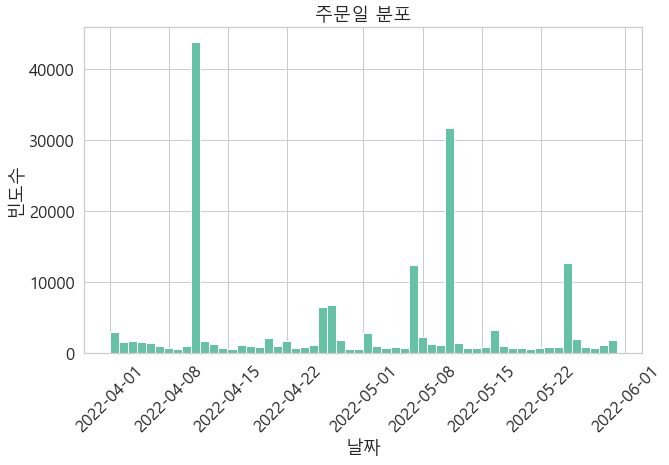

In [20]:
#주문일, 4월 11일과 5월 11일의 주문일이 몰려있는 경향 발견

df_11['주문일'] = pd.to_datetime(df_11['주문일'])
date_counts = df_11['주문일'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.hist(df_11['주문일'], bins='auto')
plt.title('주문일 분포')
plt.xlabel('날짜')
plt.ylabel('빈도수')
plt.xticks(rotation=45)
plt.show()


## 사은품 여부 

In [21]:
# 사은품여부, nan값을 제외한 상품들 중 사은품을 주는 상품들로는 꼬리곰탕, 백숫, 사골곰탕, 볶음밥의 비율이 제일 높았음  #가장 문제가 되는 nan값이 자재명에서 상품명대분류 컬럼을 방해하고 있음, 이값에 대한 정의가 필요함
df_11[df_11['사은품여부'] == 'Y']['상품명대분류'].value_counts().head()


짬뽕     109
        95
탕수육     42
깐풍기     16
짜장      13
Name: 상품명대분류, dtype: int64

## 출고예정일 

In [22]:
df_11['출고예정일'] = pd.to_datetime(df_11['출고예정일'], format = '%Y%m%d')

In [23]:
#출고예정일은 4월 13일, 5월 13일 순으로 점유율이 높음 #6월 10일과 5월 17일 # 출고예정일이 높게 나온 일들은 모두 주문일이 가장 높은 일수와 1~2일 차이가 나고 있음.
df_11['출고예정일'].value_counts(normalize = True).head()

2022-04-13    0.157971
2022-05-13    0.136770
2022-04-12    0.075080
2022-04-28    0.064456
2022-05-27    0.052870
Name: 출고예정일, dtype: float64

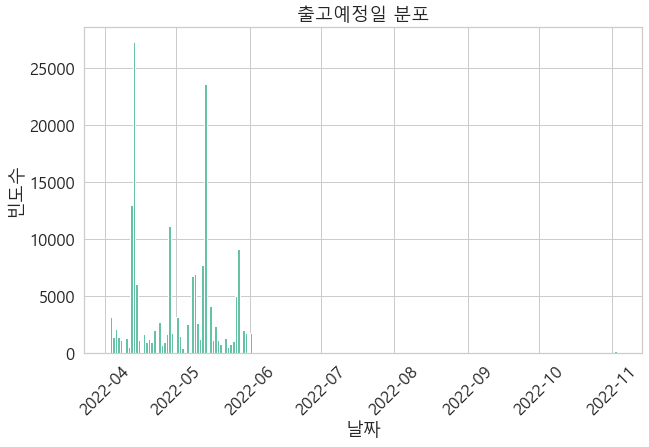

In [24]:
df_11['출고예정일'] = pd.to_datetime(df_11['출고예정일'])
date_counts = df_11['출고예정일'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.hist(df_11['출고예정일'], bins='auto')
plt.title('출고예정일 분포')
plt.xlabel('날짜')
plt.ylabel('빈도수')
plt.xticks(rotation=45)
plt.show()


## 주문/배송상태 

In [25]:
#주문/배송상태,  주문취소와 배송취소 항목을 확인하여 어떤 상품이 주문과 배송이 취소되었는 지 분석할 필요성이 있음
df_11['주문/배송상태'].value_counts(normalize= True)

배송 완료    0.977796
주문취소     0.021943
배송 취소    0.000110
배송 중     0.000093
배송 준비    0.000058
Name: 주문/배송상태, dtype: float64

In [26]:
# 주문취소상품 양념 교자 햇반 만두 죽 
df_11[df_11['주문/배송상태'] =='주문취소']['상품명대분류'].value_counts(normalize = True).head()

양념    0.255814
교자    0.142178
햇반    0.117600
만두    0.063425
죽     0.038848
Name: 상품명대분류, dtype: float64

In [27]:
# 배송취소상품 핫도그 냉면 햇반 만두 양념
df_11[df_11['주문/배송상태'] =='배송 취소']['상품명대분류'].value_counts(normalize = True).head()

핫도그    0.315789
냉면     0.157895
햇반     0.157895
만두     0.157895
양념     0.105263
Name: 상품명대분류, dtype: float64

In [28]:
#클레임상태  #주문/배송상태와는 다른 반품과 교환롼료 라는 항목이 들어있고, 그에 따른 분석 가능
df_11['클레임 상태'].value_counts(normalize= True)

-        0.975076
취소완료     0.021943
반품처리중    0.001444
교환완료     0.000899
교환처리중    0.000632
교환철회     0.000006
Name: 클레임 상태, dtype: float64

In [29]:
#주문취소상품과 동일한 퍼센트를 가지고 있음
df_11[df_11['클레임 상태'] =='취소완료']['상품명대분류'].value_counts(normalize = True).head()

양념    0.255814
교자    0.142178
햇반    0.117600
만두    0.063425
죽     0.038848
Name: 상품명대분류, dtype: float64

In [30]:
# 반품처리중 상품 햇반,설탕,볶음밥,구이,고추장
df_11[df_11['클레임 상태'] =='반품처리중']['상품명대분류'].value_counts(normalize = True).head()

양념     0.160643
교자     0.140562
햇반     0.072289
핫도그    0.068273
만두     0.044177
Name: 상품명대분류, dtype: float64

In [31]:
weight=df_11['자재명']

In [32]:
df_11['중량'] = weight.str.extract(r'(\d+)')
df_11['중량']

0         400
1         420
2         420
3         140
4         140
         ... 
172438    500
172439    500
172440    450
172441    450
172442    450
Name: 중량, Length: 172443, dtype: object

In [33]:
# # 중량 추출하기
# df_11['중량'] = df_11['자재명'].str.extract('(\d+G)')

# # 새로운 컬럼 생성
# df_11['중량(숫자)'] = df_11['중량'].str.extract('(\d+)').astype(int)


-------

In [34]:
plus = df_11[df_11['사은품여부'] =='Y']


In [35]:
gift_11 = plus[['상품명','상품명대분류','자재명','브랜드','사은품여부','구매월']] #사은품여부가 Y 인 데이터
gift = df_11[['상품명','상품명대분류','자재명','브랜드','사은품여부','구매월']] # 전체 데이터

In [40]:
df_11[df_11['사은품여부'] =='Y']['자재명'].value_counts()

고메/(리뉴얼)중화짬뽕/652G/냉동         109
nan                           95
고메 바삭쫄깃한 탕수육 450G/냉동          26
고메 바삭촉촉한 깐풍기 450G/냉동          16
CJ/고메/(리뉴얼)중화짜장/760G/냉동       13
고메 바삭쫄깃한 탕수육 900G_EBIZ/냉동      9
고메 바삭쫄깃한 사천탕수육 450G/냉동         7
고메/중화게살볶음밥840G_4P/냉동           7
고메/삼선해물볶음밥840G_4P/냉동           5
비비고/수제진한김치만두400G*2/번들/냉동       3
A)햇반/쿡반 김치치즈주먹밥 500G/냉동        3
다담/청국장찌개양념 130G/24입/냉장         1
고메치킨 달콤양념 550G/냉동              1
다담/갈치조림양념150G/냉장               1
고메치킨 후라이드 550G/냉동              1
다담/정통된장찌개양념 140G/24입/냉장        1
고메 순살치킨 허니 450G/냉동             1
다담/순두부찌개양념 140G/24입/냉장         1
햇반210G(36입)NEW/상온              1
비비고/플랜테이블왕교자420G/냉동            1
씨제이/흑당씨앗만두500G/냉동              1
CJ제일제당 고메함박스테이크 540G/냉동        1
비비고/매운왕교자 385G*2EA/냉동          1
비비고/수제군교자 360G*2EA/번들/냉동       1
비비고/수제소고기한섬320G*2/번들/냉동        1
비비고/부추새우만두509G/냉동              1
비비고/수제깔끔고기만두200G/냉동            1
고메핫도그 크리스피 480G/냉동             1
Name: 자재명, dtype: int64

In [37]:
gift_11[gift_11['자재명']=='고메/(리뉴얼)중화짬뽕/652G/냉동']

,상품명,상품명대분류,자재명,브랜드,사은품여부,구매월
83369,중화짬뽕652GX2개+(증정),짬뽕,고메/(리뉴얼)중화짬뽕/652G/냉동,고메,Y,5
83370,고메/(리뉴얼)중화짬뽕/652G/냉동,짬뽕,고메/(리뉴얼)중화짬뽕/652G/냉동,고메,Y,5
84352,고메/(리뉴얼)중화짬뽕/652G/냉동,짬뽕,고메/(리뉴얼)중화짬뽕/652G/냉동,고메,Y,5
85659,고메/(리뉴얼)중화짬뽕/652G/냉동,짬뽕,고메/(리뉴얼)중화짬뽕/652G/냉동,고메,Y,5
85820,고메/(리뉴얼)중화짬뽕/652G/냉동,짬뽕,고메/(리뉴얼)중화짬뽕/652G/냉동,고메,Y,4
...,...,...,...,...,...,...
105820,고메/(리뉴얼)중화짬뽕/652G/냉동,짬뽕,고메/(리뉴얼)중화짬뽕/652G/냉동,고메,Y,4
105825,고메/(리뉴얼)중화짬뽕/652G/냉동,짬뽕,고메/(리뉴얼)중화짬뽕/652G/냉동,고메,Y,4
105880,고메/(리뉴얼)중화짬뽕/652G/냉동,짬뽕,고메/(리뉴얼)중화짬뽕/652G/냉동,고메,Y,4
105905,고메/(리뉴얼)중화짬뽕/652G/냉동,짬뽕,고메/(리뉴얼)중화짬뽕/652G/냉동,고메,Y,4


# 짬뽕 
### 5월에 비해 4월의 구매수량 자체가 더 많았던 것으로 보아 부분 상품의 사은품 프로모션을 진행한 것으로 추측

In [38]:
gift_5 = gift[gift['구매월'] == 5]
gift_5[gift_5['자재명'] =='고메/(리뉴얼)중화짬뽕/652G/냉동']['사은품여부'].value_counts()

N    570
Y      4
Name: 사은품여부, dtype: int64

In [39]:
gift_4 = gift[gift['구매월'] == 4]
gift_4[gift_4['자재명'] =='고메/(리뉴얼)중화짬뽕/652G/냉동']['사은품여부'].value_counts()

N    1181
Y     105
Name: 사은품여부, dtype: int64